# Algotrading - Aula 10

Arbitragem Estatística
___


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from statsmodels.tsa.stattools import coint
import statsmodels.tsa.stattools as st
import time
from datetime import datetime
import random

# Para fazer o backtesting
from backtesting_v2_1 import TradingSystem, MarketData, Order, Strategy, Event, evaluateHist

___

### Ideia 1: Correlação

Ideia: Dois ativos **correlacionados** sempre andarão juntos e quando eles descasarem (um andar mais que o outro em ambas as direções) haverá uma oportunidade de arbitragem **long/short**

Metodologia:

1. Selecionar um par de instrumentos
1. Separar os dados
1. Testar se eles são correlacionados
1. Montar um índice que mede a diferença entre os movimentos
1. Testar se o índice é estacionário
1. Se for, quando o índice estiver muito alto ou muito baixo, há oportunidade de arbitragem estatística
1. Realizar um backtesting

___

Vamos lá!

1. Par mais simples e garantido: mesma empresa com ações ordinárias e preferênciais. Exemplo: PETR3 e PETR4

2. Dados:

Vamos fazer o feijão com arroz já usado nas outras aulas

In [2]:
# PETR3

import yahoofinancials as yf
ticker = 'PETR3.SA'

start_date = '2019-05-10'
end_date =  '2020-05-10'

data = yf.YahooFinancials(ticker).get_historical_price_data(start_date, end_date, 'daily')

# Ler os dados do JSON
raw = pd.DataFrame(data[ticker]['prices']).dropna()
# Converter a data para o tipo correto datetime
raw['formatted_date'] = pd.to_datetime(raw['formatted_date'])
# Indica a data como o índice de cada linha
raw = raw.set_index('formatted_date')
# Removendo as colunas que não interessam
df = raw.iloc[:,1:]

# Acertando a ordem das colunas
df = df.reindex(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume'])
# Salvando o CSV
df.to_csv('{}.csv'.format(ticker))

In [3]:
ticker = 'PETR3.SA'
PETR3 = pd.read_csv('{}.csv'.format(ticker))
PETR3

,formatted_date,open,high,low,close,adjclose,volume
0,2019-05-10,29.370001,29.420000,28.799999,29.350000,12.529033,6826500
1,2019-05-13,28.709999,29.049999,28.400000,28.510000,12.170449,10034900
2,2019-05-14,28.690001,28.830000,28.400000,28.520000,12.174721,5663500
3,2019-05-15,28.110001,28.389999,28.040001,28.320000,12.089343,10486800
4,2019-05-16,28.170000,28.709999,27.780001,27.780001,11.858827,10619100
...,...,...,...,...,...,...,...
243,2020-05-04,17.950001,18.309999,17.740000,18.049999,8.055793,17952300
244,2020-05-05,18.520000,19.139999,18.520000,18.670000,8.332501,18728700
245,2020-05-06,18.750000,18.820000,17.900000,17.940001,8.006699,19890500
246,2020-05-07,18.530001,18.730000,18.160000,18.299999,8.167368,32296200


In [4]:
# PETR4

import yahoofinancials as yf
ticker = 'PETR4.SA'

start_date = '2019-05-10'
end_date =  '2020-05-10'

data = yf.YahooFinancials(ticker).get_historical_price_data(start_date, end_date, 'daily')

# Ler os dados do JSON
raw = pd.DataFrame(data[ticker]['prices']).dropna()
# Converter a data para o tipo correto datetime
raw['formatted_date'] = pd.to_datetime(raw['formatted_date'])
# Indica a data como o índice de cada linha
raw = raw.set_index('formatted_date')
# Removendo as colunas que não interessam
df = raw.iloc[:,1:]

# Acertando a ordem das colunas
df = df.reindex(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume'])
# Salvando o CSV
df.to_csv('{}.csv'.format(ticker))

In [5]:
ticker = 'PETR4.SA'
PETR4 = pd.read_csv('{}.csv'.format(ticker))
PETR4

,formatted_date,open,high,low,close,adjclose,volume
0,2019-05-10,26.870001,26.920000,26.420000,26.680000,10.928571,33336000
1,2019-05-13,26.209999,26.469999,25.820000,25.900000,10.609069,43146100
2,2019-05-14,26.170000,26.230000,25.850000,26.000000,10.650029,34968600
3,2019-05-15,25.740000,25.889999,25.660000,25.879999,10.600877,37053900
4,2019-05-16,25.770000,26.040001,25.240000,25.270000,10.351010,46502200
...,...,...,...,...,...,...,...
243,2020-05-04,17.430000,17.620001,17.180000,17.379999,7.350846,60268400
244,2020-05-05,17.900000,18.480000,17.870001,17.940001,7.587698,75043400
245,2020-05-06,17.870001,18.059999,17.280001,17.280001,7.308551,67937500
246,2020-05-07,17.750000,17.870001,17.350000,17.440001,7.376223,81265100


Agora, antes de prosseguirmos, como estamos trabalhando com **dois instrumentos pareados**, precisamos sincronizar o dataset.

Nota: Não dá para garantir que os dados estão pareados corretamente apenas com a posição do dataset, é preciso juntá-los com alguma chave em comum

In [6]:
# Atribui os índices nos dataframes à data

PETR4.set_index('formatted_date')
PETR3.set_index('formatted_date')

# Junção dos dois dataframes, usando a data como chave comum

PETR34 = PETR3.join(PETR4, how='inner', lsuffix='_3', rsuffix='_4')

# Novo dataframe com a união dos dois anteriores
PETR34

,formatted_date_3,open_3,high_3,low_3,close_3,adjclose_3,volume_3,formatted_date_4,open_4,high_4,low_4,close_4,adjclose_4,volume_4
0,2019-05-10,29.370001,29.420000,28.799999,29.350000,12.529033,6826500,2019-05-10,26.870001,26.920000,26.420000,26.680000,10.928571,33336000
1,2019-05-13,28.709999,29.049999,28.400000,28.510000,12.170449,10034900,2019-05-13,26.209999,26.469999,25.820000,25.900000,10.609069,43146100
2,2019-05-14,28.690001,28.830000,28.400000,28.520000,12.174721,5663500,2019-05-14,26.170000,26.230000,25.850000,26.000000,10.650029,34968600
3,2019-05-15,28.110001,28.389999,28.040001,28.320000,12.089343,10486800,2019-05-15,25.740000,25.889999,25.660000,25.879999,10.600877,37053900
4,2019-05-16,28.170000,28.709999,27.780001,27.780001,11.858827,10619100,2019-05-16,25.770000,26.040001,25.240000,25.270000,10.351010,46502200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2020-05-04,17.950001,18.309999,17.740000,18.049999,8.055793,17952300,2020-05-04,17.430000,17.620001,17.180000,17.379999,7.350846,60268400
244,2020-05-05,18.520000,19.139999,18.520000,18.670000,8.332501,18728700,2020-05-05,17.900000,18.480000,17.870001,17.940001,7.587698,75043400
245,2020-05-06,18.750000,18.820000,17.900000,17.940001,8.006699,19890500,2020-05-06,17.870001,18.059999,17.280001,17.280001,7.308551,67937500
246,2020-05-07,18.530001,18.730000,18.160000,18.299999,8.167368,32296200,2020-05-07,17.750000,17.870001,17.350000,17.440001,7.376223,81265100


3. Para analisar a correlação, vamos fazer uma inspeção visual na série de preços

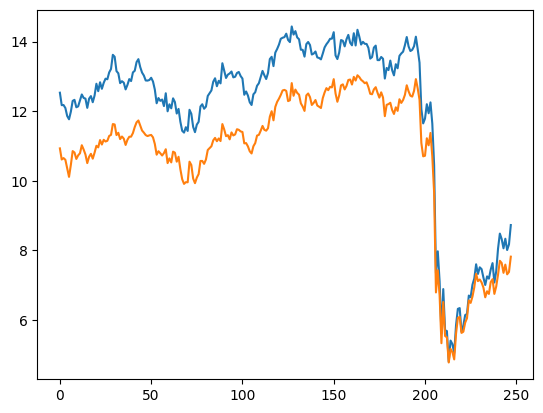

In [7]:
plt.plot(PETR34.adjclose_3);
plt.plot(PETR34.adjclose_4);

Também na dispersão

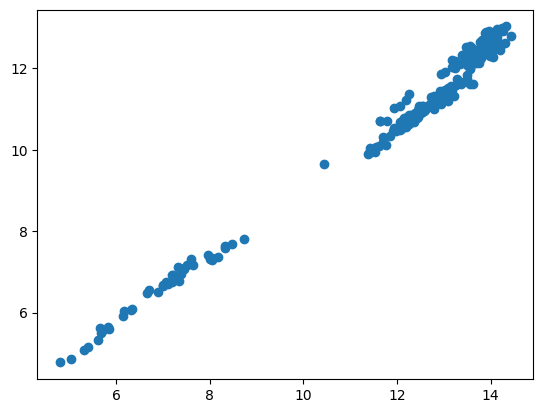

In [8]:
plt.scatter(PETR34.adjclose_3, PETR34.adjclose_4);

Como esperado, andam muito próximas, mas cuidado que o gráfico engana. Vamos testar a correção via Coef de Spearman:

$$H_0: \rho=0$$

Nota: Não é adequado usar o coeficiente de Pearson, quando as séries não são normais.

In [9]:
spearmanr(PETR34.adjclose_3, PETR34.adjclose_4)

SignificanceResult(statistic=0.9811949633213202, pvalue=9.3751949962528e-178)

4. Montagem de um índice de spread

Tentativa 1: analisar as diferenças dos retornos acumulados a partir de uma data inicial.

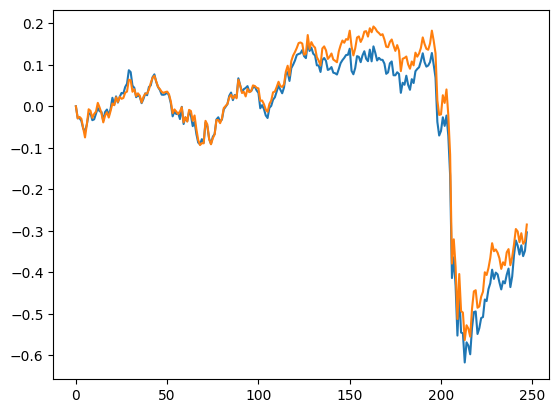

In [10]:
ret3 = PETR34.adjclose_3/PETR34.adjclose_3[0]-1
plt.plot(ret3);
ret4 = PETR34.adjclose_4/PETR34.adjclose_4[0]-1
plt.plot(ret4);

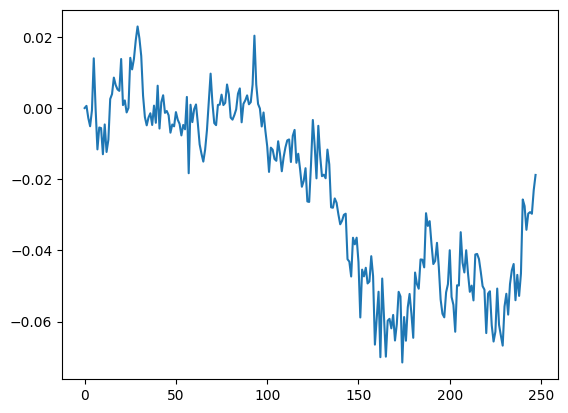

In [11]:
plt.plot(ret3-ret4);

Será que parece uma boa ideia??? E se trocar a janela de dados?
___
Tentativa 2: Analisar a diferença de retornos, mas não acumulados

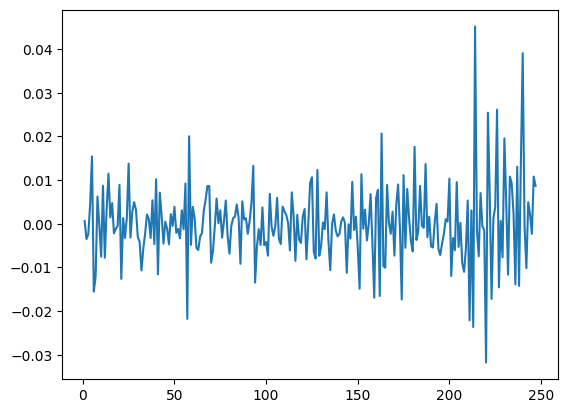

In [12]:
PETR34['diff'] = PETR34.adjclose_3.pct_change()-PETR34.adjclose_4.pct_change()
PETR34 = PETR34.dropna()
plt.plot(PETR34['diff']);

5. Agora parece bom, mas será que essa série de diferenças é estacionária? 

Vamos testar: Dick Fuller Test

$H_0$: Tem raiz unitária (série não é estacionária)

$H_A$: Não tem raiz unitária

In [13]:
import pandas.testing as tm
from statsmodels.tsa.stattools import adfuller

adf, pvalue, *_ = adfuller(PETR34['diff'])
print(pvalue)

3.052636114404506e-22


ótimo! Agora só falta decidir uma banda de entrada tanto superior, quanto inferior. Uma ideia é usar os quartis:

In [14]:
metrics = PETR34['diff'].describe()
metrics

count    247.000000
mean       0.000002
std        0.008885
min       -0.031787
25%       -0.004695
50%       -0.000263
75%        0.004319
max        0.045209
Name: diff, dtype: float64

6. Trading Idea:


- Se o índice (diff) estiver acima do terceiro quartil, vende o spread (muito positivo, vende PETR3 e compra PETR4)
- Se o índice (diff) estiver abaixo do primeiro quartil, compra o spread (muito negativo, compra PETR3 e vende PETR4)


Vamos salvar os dados para fazer o Backtesting

In [15]:
PETR34diff = pd.DataFrame({'formatted_date': PETR34['formatted_date_3'],
                    'open': PETR34['open_3'],
                    'high': PETR34['high_3'],
                    'low': PETR34['low_3'],
                    'close': PETR34['close_3'],
                    'adjclose': PETR34['diff'],
                    'volume': 0,
                   })
PETR34diff = PETR34diff.set_index('formatted_date')
PETR34diff

,open,high,low,close,adjclose,volume
formatted_date,,,,,,
2019-05-13,28.709999,29.049999,28.400000,28.510000,0.000615,0
2019-05-14,28.690001,28.830000,28.400000,28.520000,-0.003510,0
2019-05-15,28.110001,28.389999,28.040001,28.320000,-0.002397,0
2019-05-16,28.170000,28.709999,27.780001,27.780001,0.004503,0
2019-05-17,27.530001,28.180000,27.430000,27.559999,0.015428,0
...,...,...,...,...,...,...
2020-05-04,17.950001,18.309999,17.740000,18.049999,0.004948,0
2020-05-05,18.520000,19.139999,18.520000,18.670000,0.002128,0
2020-05-06,18.750000,18.820000,17.900000,17.940001,-0.002311,0


In [16]:
PETR34diff.to_csv('PETR34diff.csv')

7. Montar o Backtesting e analisar os resultados!

In [17]:
class LongShort(Strategy):
    
    def __init__(self, uband, lband):
        self.prices = []
        self.indicator = []
        
        self.side = 0
        
        self.uband = uband
        self.lband = lband
        
    def receive(self, event):
        
        orders = []
        if event.instrument == 'PETR34diff':

            price = event.price[3] # Captura o spread

            # Montando a série de preços:
            self.prices.append(price)

            if price > self.uband:
                signal = -1 # Sell PETR3, buy PETR4
            elif price < self.lband:
                signal = 1 # Buy PETR3, sell PETR4

            if self.side != signal:
                
                # Vamos user o mesmo tamanho porque eles tem preços semelhantes!
                # Mas não é o ideal!
                
                
                if self.side > 0: # Se está comprado em PETR3, vende PETR3 e compra PETR4
                    self.submit(self.id, Order('PETR3', Order.S, 50*self.side, 0))
                    self.submit(self.id, Order('PETR4', Order.B, 50*self.side, 0))
                elif self.side < 0: # Senão faz o inverso
                    self.submit(self.id, Order('PETR3', Order.B, 50*self.side, 0))
                    self.submit(self.id, Order('PETR4', Order.S, 50*self.side, 0))
                
                if signal > 0: # Se quer comprar PETR3, compra PETR3 e vende PETR4
                    self.submit(self.id, Order('PETR3', Order.B, 50*signal, 0))
                    self.submit(self.id, Order('PETR4', Order.S, 50*signal, 0))
                elif signal < 0: # Senão faz o inverso
                    self.submit(self.id, Order('PETR3', Order.S, 50*signal, 0))
                    self.submit(self.id, Order('PETR4', Order.B, 50*signal, 0))

                self.side = signal
        
        return orders
    
    
model = LongShort(metrics[4], metrics[6])
print(evaluateHist(model, {'PETR3': 'PETR3.SA.csv', 'PETR4': 'PETR4.SA.csv', 'PETR34diff': 'PETR34diff.csv'}))

Gross Profit: $332.02
Gross Loss: $-141.94
Gross Total: $190.09

Number of trades: 99
Hitting Ratio: 69.70%
Number of profit trades: 69
Number of loss trades: 30
Average number of events per trade: 2.48

Max win trade: $14.96
Avg win trade: $4.81
Max loss trade: $-12.65
Avg loss trade: $-4.73
Avg all trades: $1.92
Win/Loss ratio: 1.02

Max Profit: $69.67
Max Profit High/Low: $139.71
Max Drawdown: $-154.97
Max Drawdown High/Low: $-344.95

Max Allocation: $716.92
Avg Allocation: $574.74
Max Cash Required (margin): $716.92

Gross Total: $190.09
Total Fees: $39.60
Total Taxes: $50.88
Net Total: $99.61

Gross Return: 39.85%
Average Return: 0.40%
Net Return: 22.28%
Net Return Avg Alocation: 17.33%

Number of days: 248
Initial Capital: $10000.00
Risk Free Rate: 13.75% yearly/0.0511% daily
Total Carry: $1276.05
Net Total + Carry: $1375.66
Net Return Capital: 13.76%
Net Return Capital Yearly: 13.99%




Agora é com vocês. Não precisa ficar preso ao par ON/PN, você pode procurar outros pares que cumprem os requisitos anteriores e testar a ideia!

Ideia:

In [18]:
# Top 10 ações do IBOV em peso
IBOV = ['VALE3.SA', 'ITUB4.SA', 'PETR4.SA', 'B3SA3.SA', 'BBDC4.SA', 'ABEV3.SA',
        'MGLU3.SA', 'GOLL4.SA', 'WEGE3.SA', 'SUZB3.SA'] #etc

#puxar as séries:

for ticker in IBOV:

    start_date = '2018-05-10'
    end_date =  '2020-05-10'

    data = yf.YahooFinancials(ticker).get_historical_price_data(start_date, end_date, 'daily')

    # Ler os dados do JSON
    raw = pd.DataFrame(data[ticker]['prices']).dropna()
    # Converter a data para o tipo correto datetime
    raw['formatted_date'] = pd.to_datetime(raw['formatted_date'])
    # Indica a data como o índice de cada linha
    raw = raw.set_index('formatted_date')
    # Removendo as colunas que não interessam
    df = raw.iloc[:,1:]

    # Acertando a ordem das colunas
    df = df.reindex(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume'])
    # Salvando o CSV
    df.to_csv('{}.csv'.format(ticker))
            

In [19]:
# Montar os pares e testar:
for i in range(len(IBOV)):
    for j in range(i+1, len(IBOV)):
        ticker1 = IBOV[i]
        ticker2 = IBOV[j]
        
        if ticker1 != ticker2:
            data1 = pd.read_csv('{}.csv'.format(ticker1))
            data2 = pd.read_csv('{}.csv'.format(ticker2))
            
            
            data1.set_index('formatted_date')
            data2.set_index('formatted_date')

            # Junção dos dois dataframes, usando a data como chave comum

            pair = data1.join(data2, how='inner', lsuffix='_1', rsuffix='_2')
            print('{}/{}:'.format(ticker1, ticker2))
            print(spearmanr(pair.adjclose_1, pair.adjclose_2))

            diff = pair.adjclose_1.pct_change().dropna()-pair.adjclose_2.pct_change().dropna()
            adf, pvalue, *_ = adfuller(diff)
            print('ADFuller: {}'.format(pvalue))


VALE3.SA/ITUB4.SA:
SignificanceResult(statistic=0.09193680267753915, pvalue=0.041303577755766686)
ADFuller: 2.0903469079826653e-30
VALE3.SA/PETR4.SA:
SignificanceResult(statistic=0.2406794527940916, pvalue=6.298500658953375e-08)
ADFuller: 1.0097651377017464e-29
VALE3.SA/B3SA3.SA:
SignificanceResult(statistic=-0.22620254435122844, pvalue=3.8607698130785114e-07)
ADFuller: 4.350099620044857e-30
VALE3.SA/BBDC4.SA:
SignificanceResult(statistic=0.11498798421917711, pvalue=0.010614297425940679)
ADFuller: 4.197204822181456e-11
VALE3.SA/ABEV3.SA:
SignificanceResult(statistic=0.12327465089810369, pvalue=0.006131707537933347)
ADFuller: 4.1768314565065494e-10
VALE3.SA/MGLU3.SA:
SignificanceResult(statistic=-0.2316438942617242, pvalue=1.980251197635159e-07)
ADFuller: 8.096771732172551e-23
VALE3.SA/GOLL4.SA:
SignificanceResult(statistic=0.01953701713718713, pvalue=0.6652092478556704)
ADFuller: 2.179691913617402e-16
VALE3.SA/WEGE3.SA:
SignificanceResult(statistic=-0.17579855903571773, pvalue=8.707106

Parece simples, **MAS** ainda precisa acertar o tamanho da posição:

* Ambas as posição precisam ter (quase) a mesma quantidade de dinheiro
* Ambas as ordens precisam ter uma quantidade múltipla de 100 (para o caso das ações envolvidas)

Lembrando que a mesma quantidade compradas deve ser a mesma quantidade vendida!

___

### Ideia 2: Co-integração

Co-integration

Uma outra forma de relacionar duas séries é via co-integração. No caso de pares, esse método vai regredir um instrumento em relação ao outro e analisar os resíduos $\epsilon$:

$$y_i=\beta x_i + \epsilon_i$$

isolando o resíduo temos:

$$\epsilon_i = y_i - \beta x_i$$

A hipótese é que a série dos resíduos é estacionária e sempre reverte à média (zero). Vamos analisar!

In [20]:
ticker1 = 'MGLU3.SA'
ticker2 = 'SUZB3.SA'
data1 = pd.read_csv('{}.csv'.format(ticker1))
data2 = pd.read_csv('{}.csv'.format(ticker2))


data1.set_index('formatted_date')
data2.set_index('formatted_date')

# Junção dos dois dataframes, usando a data como chave comum

pair = data1.join(data2, how='inner', lsuffix='_1', rsuffix='_2')

In [21]:
pair.head()

,formatted_date_1,open_1,high_1,low_1,close_1,adjclose_1,volume_1,formatted_date_2,open_2,high_2,low_2,close_2,adjclose_2,volume_2
0,2018-05-10,3.519687,3.578125,3.421875,3.421875,3.310558,61299200,2018-05-10,42.549999,43.349998,41.619999,42.020000,38.629807,4827600
1,2018-05-11,3.421875,3.474687,3.334375,3.395312,3.284859,46371200,2018-05-11,41.779999,43.849998,41.200001,43.099998,39.622669,3836300
2,2018-05-14,3.425000,3.458750,3.294062,3.379687,3.269743,47523200,2018-05-14,43.000000,45.279999,42.950001,45.250000,41.599209,4926200
3,2018-05-15,3.379687,3.454375,3.306250,3.327187,3.218951,53561600,2018-05-15,47.209999,47.840000,45.650002,45.990002,42.279503,6523300
4,2018-05-16,3.314062,3.569687,3.314062,3.506562,3.392490,68899200,2018-05-16,46.389999,46.900002,43.919998,44.490002,40.900528,4258800


Teste de Engle-Granger aumentado para saber se as séries co-integram:

$H_0$: não são co-integradas

$H_A$: são co-integradas

Vamos user apenas o último ano para analisar:

In [22]:
print(coint(pair.adjclose_1[252:], pair.adjclose_2[252:]))

(-3.9888717032005654, 0.007448031774719978, array([-3.94265498, -3.3617072 , -3.06216889]))


O segundo valor é o valor-p.

Próximo passo é regredir as séries e analisar o resíduo

In [23]:
import statsmodels.api as sm

y = pair.adjclose_2[252:]
x = pair.adjclose_1[252:]

model = sm.OLS(y,x)

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             adjclose_2   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.974
Method:                 Least Squares   F-statistic:                              8934.
Date:                Sun, 14 May 2023   Prob (F-statistic):                   6.81e-192
Time:                        12:07:46   Log-Likelihood:                         -749.74
No. Observations:                 241   AIC:                                      1501.
Df Residuals:                     240   BIC:                                      1505.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
adjclose_1     3.2445      0.034     94.522      0.000       3.177       3.312
==============================================================================
Omnibus:                       18.686   Durbin-Watson:                   0.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.748
Skew:                           0.701   Prob(JB):                     3.12e-05
Kurtosis:                       3.317   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

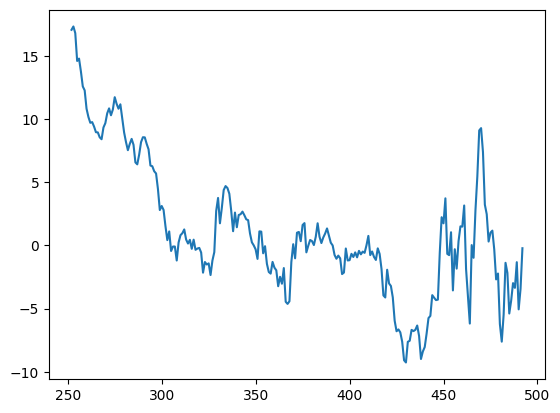

In [24]:
plt.plot(results.resid);

Vamos realizar um teste de estacionariedade da série de resíduos, semelhante à ideia 1:

In [25]:
adf, pvalue, *_ = adfuller(results.resid)
pvalue

0.01945177795533734

Uma vez analisado à reversão para a média zero, vamos à estratégia:

* Se está posicionado e o resíduo cruzou o zero, zera-se a posição
* Se as séries co-integram no período analisado e
  * Se o resíduo está acima de um patamar (2 desvios por exemplo), compra x e vende y
  * Se o resíduo está abaixo de um patamar (-2 desvios por exemplo), compra y e vende x
  
Um detalhe muito importante, a quantidade de compra e venda de x vai depender do $\beta$ da regressão

Backtesting:

In [26]:
class Coint(Strategy):

    def __init__(self, ticker1, ticker2):
        self.prices1 = []
        self.prices2 = []
        self.indicator1 = []
        self.indicator2 = []
        
        self.qty1 = 0
        self.qty2 = 0
        
        self.ticker1 = ticker1
        self.ticker2 = ticker2
        
        self.tam = 60
        
        self.side = 0
        
    def receive(self, event):
        
        orders = []
        
        # Armazenando os preços:
        if event.instrument == self.ticker1:
            self.prices1.append(event.price[3])
        elif event.instrument == self.ticker2:
            self.prices2.append(event.price[3])
        
        # Precisa sincronizar os preços
        tam = min(len(self.prices1), len(self.prices2))
        if tam >= self.tam and len(self.prices1) == len(self.prices2):
            
            y = self.prices1[-self.tam:]
            x = self.prices2[-self.tam:]
            
            # Teste da cointegração
            _, pvalue, _ = coint(x, y)
            self.indicator1.append(pvalue)
            
            # Regressão
            model = st.OLS(y,x)
            results = model.fit()
            
            self.indicator2.append(results.resid[-1])
            
            signal = self.side
            
            if signal < 0 and results.resid[-1] < 0: # Condição para zerar
                signal = 0
            elif signal > 0 and results.resid[-1] > 0: # Condição para zerar
                signal = 0
                
            elif pvalue < 1 and len(self.indicator2) > self.tam: # Condição para entrar
                
                # Usando uma espécie de Bollinger Bands, a média será zero por construção
                if results.resid[-1] < -2*np.std(self.indicator2[-self.tam:]):
                    signal = 1
                elif results.resid[-1] > 2*np.std(self.indicator2[-self.tam:]):
                    signal = -1
                    
            if self.side != signal:
                
                # Zeragem ticker1:
                if self.qty1 > 0:
                    self.submit(self.id, Order(self.ticker1, Order.S, self.qty1, 0))
                elif self.qty1 < 0: 
                    self.submit(self.id, Order(self.ticker1, Order.B, self.qty1, 0))
                
                # Zeragem ticker2:
                if self.qty2 > 0:
                    self.submit(self.id, Order(self.ticker2, Order.S, self.qty2, 0))
                elif self.qty2 < 0: 
                    self.submit(self.id, Order(self.ticker2, Order.B, self.qty2, 0))
                    
                # Cálculo das novas quantidades corretas
                self.qty2 = 200 * signal
                self.qty1 = -int(200 / results.params[0]) * signal
                
#                 print(results.params[0])
               
                # Montagem da posição
                if self.qty1 > 0:
                    self.submit(self.id, Order(self.ticker1, Order.B, self.qty1, 0))
                elif self.qty1 < 0: 
                    self.submit(self.id, Order(self.ticker1, Order.SS, self.qty1, 0))
                
                if self.qty2 > 0:
                    self.submit(self.id, Order(self.ticker2, Order.B, self.qty2, 0))
                elif self.qty2 < 0: 
                    self.submit(self.id, Order(self.ticker2, Order.SS, self.qty2, 0))

                self.side = signal                

    def fill(self, id, instrument, price, quantity, status):
        
        # Imprimindo o preenchimento das ordens
        if quantity != 0:
            print('Fill: {0} {1}@{2}'.format(instrument, quantity, price))

In [27]:
model = Coint('MGLU3', 'SUZB3')

print(evaluateHist(model, {'MGLU3': 'MGLU3.SA.csv', 'SUZB3': 'SUZB3.SA.csv'}))

Fill: MGLU3 2061@5.117608547210693
Fill: SUZB3 -200@33.62870788574219
Fill: MGLU3 -2061@5.367977142333984
Fill: SUZB3 200@38.88721466064453
Fill: MGLU3 1614@5.814599990844727
Fill: SUZB3 -200@38.26619338989258
Fill: MGLU3 -1614@8.293540954589844
Fill: SUZB3 200@31.285642623901367
Fill: MGLU3 636@13.656296730041504
Fill: SUZB3 -200@40.351905822753906
Fill: MGLU3 -636@12.7905855178833
Fill: SUZB3 200@40.906219482421875
Fill: MGLU3 -597@11.654186248779297
Fill: SUZB3 200@40.0418701171875
Fill: MGLU3 597@10.242222785949707
Fill: SUZB3 -200@29.66969108581543
Fill: MGLU3 -596@9.139966011047363
Fill: SUZB3 200@35.118839263916016
Fill: MGLU3 596@11.306522369384766
Fill: SUZB3 -200@33.99142837524414
Gross Profit: $5397.12
Gross Loss: $-3945.39
Gross Total: $1451.73

Number of trades: 5
Hitting Ratio: 20.00%
Number of profit trades: 1
Number of loss trades: 4
Average number of events per trade: 37.80

Max win trade: $5397.12
Avg win trade: $5397.12
Max loss trade: $-1516.75
Avg loss trade: $-986

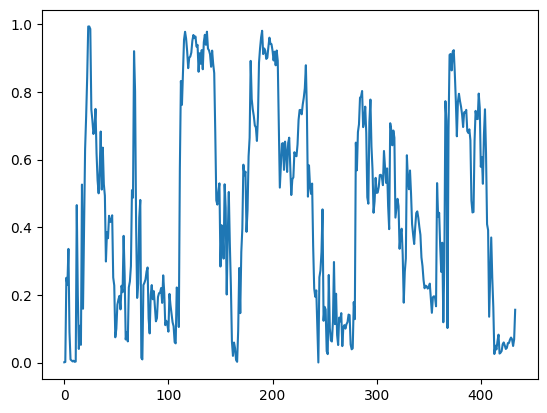

In [28]:
plt.plot(model.indicator1);

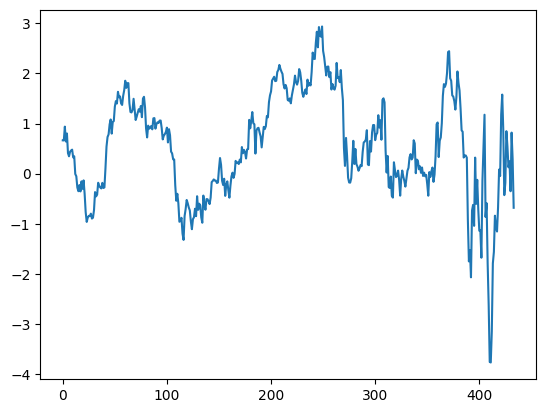

In [29]:
plt.plot(model.indicator2);

Um detalhe final é uma atenção acerca do rolling window vs expanding window, visto em aulas anteriores.

___

### Ideia 3: Arbitragem de Volatilidade

Ideia breve: Se a estimativa de volatilidade implícita futura é muito diferente da volatilidade implícita das opções disponíveis no mercado, compra/vende a opção e vende/compra o ativo objeto zerando a exposição em delta correspondente.

Apesar do risco parecer zerado (em delta), ainda pode haver exposição em gamma. Tem que ficar sempre zerando o delta quando o ativo objeto se movimenta.

Nota: é necessário ter o cálculo das gregas e um modelo de volatilidade para realizar esse backtesting mais complexo. Mais detalhes: Livro do Barry Johnson, Cap. 13.

___

### Lista: Exercício 3 - 16/Mai até 9h30

* Modificar a ideia 1 da aula de hoje para simular pares de até 3 ações americanas correlacionadas.
* Selecionar entre 1 ano e 2 anos de dados
* Precisa ajustar as quantidades para que tenham o mesmo valor financeiro. As quantidades serão inteiros múltiplos de 1.
* Entregar um **PDF** com o código e o gráfico da simulação do resultado
* Prazo: 16/Mai até 9h30 via Blackboard (Após esse prazo será considerado atrasado)
* Estritamente individual